In [13]:
import sys
import os
import random
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator 
from qiskit import transpile
from qiskit.visualization import plot_histogram
# Adjust the path to the directory containing 'scripts/algo'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts')))
from algo.qft_qpe_qdrift import *
from utils.scalable_numerical_tests import *

In [14]:
num_qubits = 2
num_terms = 50
# Generate a random Hamiltonian
hamiltonian_terms = generate_random_hamiltonian(num_qubits, num_terms)
H = construct_hamiltonian(hamiltonian_terms)
eigenvalues, eigenvectors = get_eigenvalues_vectors(H)

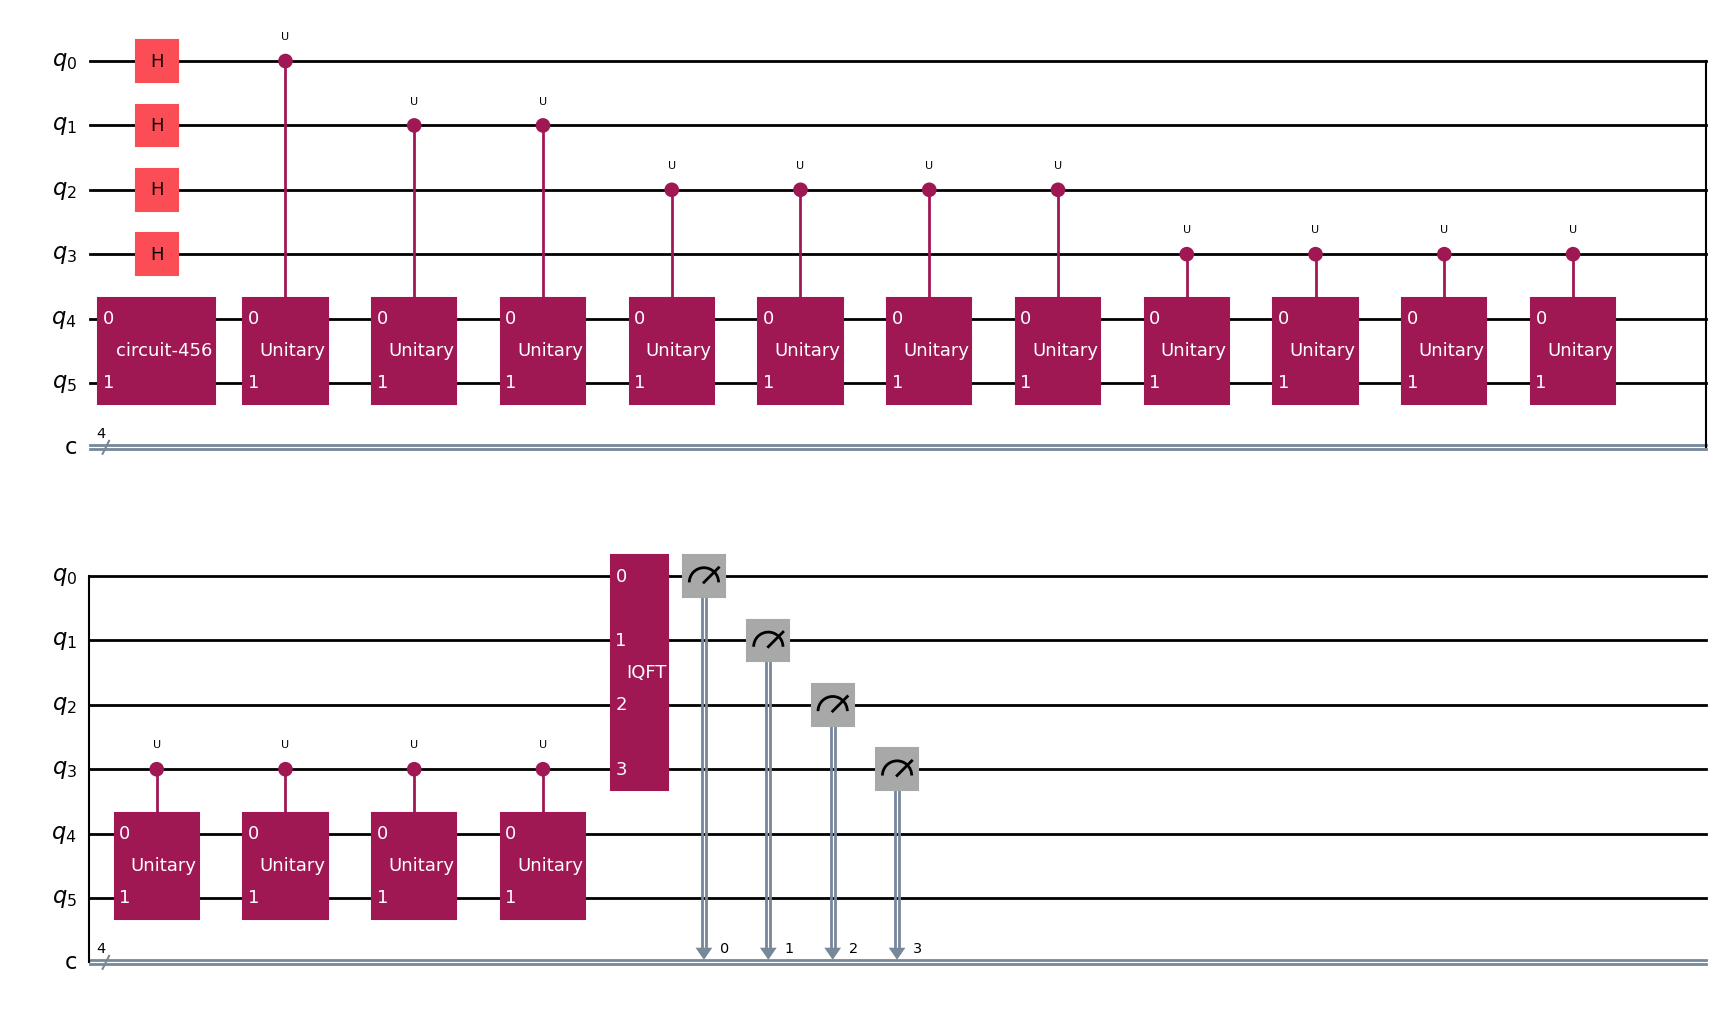

In [15]:
def exponentiate_hamiltonian(hamiltonian: SparsePauliOp, time: float) -> Operator:
    """Exponentiates the Hamiltonian to obtain U = e^(-i H t)."""
    matrix = hamiltonian.to_matrix()
    unitary_matrix = scipy.linalg.expm(1j * time * matrix)
    return Operator(unitary_matrix)

def eigenvector_to_circuit(eigenvector: np.ndarray) -> QuantumCircuit:
    """Creates a quantum circuit that prepares a given eigenvector."""
    num_qubits = int(np.log2(len(eigenvector)))  # Number of qubits
    statevector = Statevector(eigenvector)  # Convert to Qiskit state
    qc = QuantumCircuit(num_qubits)
    qc.initialize(statevector)  # Initialize circuit with eigenstate
    return qc

j = random.randint(0, len(eigenvalues) - 1)
rand_eigenstate, rand_eigenvalue = eigenvectors[j], eigenvalues[j]
qc_eigenstate = eigenvector_to_circuit(rand_eigenstate)

time = 1
U = exponentiate_hamiltonian(H, time)
# Run the QPE algorithm
qpe_circuit = standard_qpe(unitary=U, eigenstate=qc_eigenstate, num_ancilla=4)  

qpe_circuit.draw('mpl')

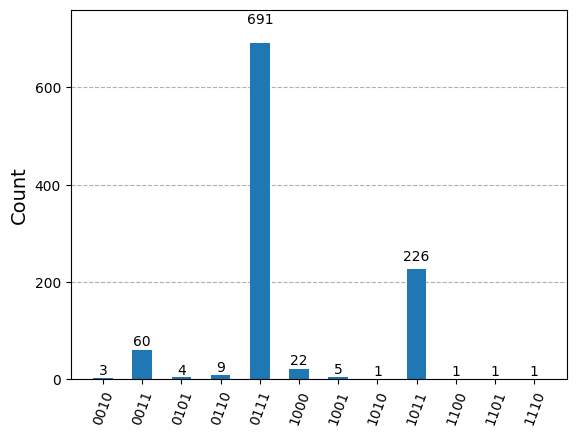

In [16]:
# Simulate the QPE circuit
simulator = AerSimulator()
qpe_circuit_transpiled = transpile(qpe_circuit, simulator)
result = simulator.run(qpe_circuit_transpiled).result()
counts = result.get_counts(qpe_circuit_transpiled)
plot_histogram(counts)


In [18]:
phase = int(max(counts, key=counts.get), 2) / 2**4
print(f"Estimated phase: {phase}")
print(f"Actual phase: {rand_eigenvalue * time % 1}")

Estimated phase: 0.4375
Actual phase: 0.7484826524884074


In [33]:
times = [1, 2, 5, 10]
phases = []
for t in times:
    U = exponentiate_hamiltonian(H, t)
    qpe_circuit = standard_qpe(unitary=U, eigenstate=qc_eigenstate, num_ancilla=4)
    qpe_circuit_transpiled = transpile(qpe_circuit, simulator)
    result = simulator.run(qpe_circuit_transpiled).result()
    counts = result.get_counts(qpe_circuit_transpiled)
    most_common_bitstring = max(counts, key=counts.get)
    print(f"t = {t}, estimated phase = {most_common_bitstring}")
    # we need to scale the phase by the time t
    phase = np.pi * 2 * int(most_common_bitstring, 2) / (2**4 * t )
    phases.append(phase)

t = 1, estimated phase = 0111
t = 2, estimated phase = 1110
t = 5, estimated phase = 0100
t = 10, estimated phase = 1000


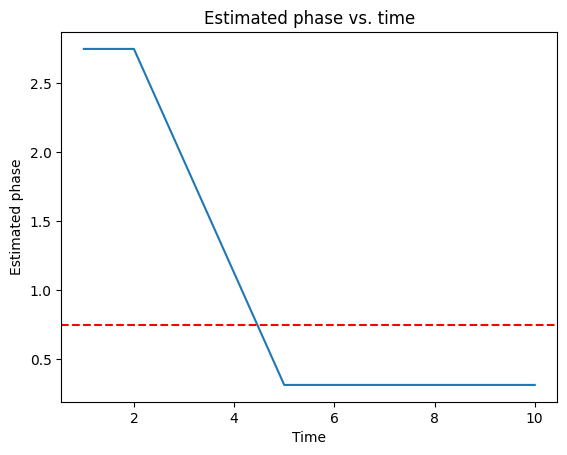

In [34]:
plt.plot(times, phases)
plt.xlabel("Time")
plt.ylabel("Estimated phase")
plt.title("Estimated phase vs. time")
# draw the actual phase as a horizontal line
plt.axhline(y=rand_eigenvalue % 1, color='r', linestyle='--')
plt.show()